## Cek jumlah beserta struktur datasets

In [1]:
import os

root_path = "D:\Pothole Vision - AI Road Damage Detection\dataset\RDD2022_all_countries"
def count_files(path):
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]) if os.path.exists(path) else 0

summary = []

for country in os.listdir(root_path):
    country_path = os.path.join(root_path, country)
    if os.path.isdir(country_path):
        train_images = count_files(os.path.join(country_path, "train", "images"))
        test_images = count_files(os.path.join(country_path, "test", "images"))
        xml_files = count_files(os.path.join(country_path, "train", "annotations", "xmls"))
        summary.append(f"{country} -> Train Images: {train_images}, Test Images: {test_images}, Annotations: {xml_files}")

for line in summary:
    print(line)

China_Drone -> Train Images: 2401, Test Images: 0, Annotations: 2401
China_MotorBike -> Train Images: 1977, Test Images: 500, Annotations: 1977
Czech -> Train Images: 2829, Test Images: 709, Annotations: 2829
India -> Train Images: 7706, Test Images: 1959, Annotations: 7706
Japan -> Train Images: 10506, Test Images: 2627, Annotations: 10506
Norway -> Train Images: 8161, Test Images: 2040, Annotations: 8161
United_States -> Train Images: 4805, Test Images: 1200, Annotations: 4805


## Issue #1 Folder test China_drone [SOLVED]
China_drone tidak punya folder test, abaikan?
Selanjutnya Saya akan split datset dari Train & Test menjadi Train, Test, & Val


## Issue #2 Struktur dataset [SOLVED]
Jika dataset DIGABUNG semua negara menjadi satu dataset besar:
Keuntungan:

Model akan lebih general karena belajar dari berbagai jenis jalan, cuaca, kamera.

Bisa membantu jika nanti digunakan di Indonesia yang belum punya data.

Jumlah data menjadi sangat besar (10.000++), sangat bagus untuk deep learning.

Kekurangan:

Bisa menyebabkan bias ke negara dengan data terbanyak (misalnya India, Japan).

Anotasi antar negara mungkin memiliki inkonsistensi kecil (labeling style, noise).

Rekomendasi untuk kasus ini:
Karena kamu akan pakai untuk Indonesia, tapi belum punya data lokal, maka:

Gabungkan semua negara → latih model global, supaya kuat terhadap variasi.

Simpan metadata negara asalnya → bisa dipakai untuk evaluasi per negara.

Nanti, jika ada data Indonesia, kamu bisa fine-tune model global ke data lokal.

In [2]:
import os
import xml.etree.ElementTree as ET
from collections import Counter

root_path = "dataset/RDD2022_all_countries"

country_folders = [
    "China_Drone", "China_MotorBike", "Czech",
    "India", "Japan", "Norway", "United_States"
]

all_labels = []

for country in country_folders:
    annotation_folder = os.path.join(root_path, country, "train", "annotations", "xmls")
    if os.path.exists(annotation_folder):
        for filename in os.listdir(annotation_folder):
            if filename.endswith('.xml'):
                file_path = os.path.join(annotation_folder, filename)
                try:
                    tree = ET.parse(file_path)
                    root = tree.getroot()
                    for obj in root.findall('object'):
                        label = obj.find('name').text.strip()
                        all_labels.append(label)
                except Exception as e:
                    print(f"❌ Error parsing {file_path}: {e}")

label_counts = Counter(all_labels)

print("Distribusi label di semua dataset mentah:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Distribusi label di semua dataset mentah:
D10: 11830
D00: 26016
D20: 10617
Repair: 1046
D40: 6544
Block crack: 3
D44: 5057
D01: 179
D11: 45
D50: 3581
D43: 793
D0w0: 1


In [3]:
import os
import xml.etree.ElementTree as ET

root_path = "dataset/RDD2022_all_countries"

def clean_annotations(root_path, target_label='D00'):
    removed_files = 0
    kept_files = 0
    for country in os.listdir(root_path):
        country_path = os.path.join(root_path, country)
        if not os.path.isdir(country_path):
            continue

        # Proses folder train annotations (ubah jika perlu val/test juga)
        annotations_dir = os.path.join(country_path, 'train', 'annotations', 'xmls')
        images_dir = os.path.join(country_path, 'train', 'images')

        if not os.path.exists(annotations_dir):
            print(f"Folder anotasi tidak ditemukan: {annotations_dir}, dilewati.")
            continue

        for xml_file in os.listdir(annotations_dir):
            if not xml_file.endswith('.xml'):
                continue

            xml_path = os.path.join(annotations_dir, xml_file)
            image_file = xml_file.replace('.xml', '.jpg')
            image_path = os.path.join(images_dir, image_file)

            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Cari objek yang labelnya bukan target_label, hapus mereka
            objects = root.findall('object')
            removed_objs = 0
            for obj in objects:
                label = obj.find('name').text.strip()
                if label != target_label:
                    root.remove(obj)
                    removed_objs += 1

            # Cek apakah setelah penghapusan masih ada objek
            if len(root.findall('object')) == 0:
                # Hapus XML dan gambarnya
                os.remove(xml_path)
                if os.path.exists(image_path):
                    os.remove(image_path)
                removed_files += 1
            else:
                # Simpan ulang XML yang sudah dibersihkan
                tree.write(xml_path)
                kept_files += 1

    print(f"Proses selesai.")
    print(f"File XML dan gambar yang dihapus: {removed_files}")
    print(f"File XML yang dipertahankan: {kept_files}")

clean_annotations(root_path)

Proses selesai.
File XML dan gambar yang dihapus: 24837
File XML yang dipertahankan: 13548


In [4]:
import os
import random
import shutil
import pandas as pd

# Lokasi dataset dan output
root_path = "D:\\Pothole Vision - AI Road Damage Detection\\dataset\\RDD2022_all_countries"
output_path = "D:\\Pothole Vision - AI Road Damage Detection\\dataset-mix"
train_val_split = 0.8  # 80% untuk train, 20% untuk val

# Membuat direktori output
os.makedirs(os.path.join(output_path, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'train', 'annotations'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'val', 'annotations'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'test', 'images'), exist_ok=True)

# Metadata untuk csv
metadata = []

def copy_file(src_file, dest_file):
    shutil.copy(src_file, dest_file)

# Proses per negara
for country in os.listdir(root_path):
    country_path = os.path.join(root_path, country)
    if not os.path.isdir(country_path):
        continue

    images_path = os.path.join(country_path, 'train', 'images')
    annotations_path = os.path.join(country_path, 'train', 'annotations', 'xmls')

    if not os.path.exists(images_path) or not os.path.exists(annotations_path):
        continue

    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])
    annotation_files = sorted([f for f in os.listdir(annotations_path) if f.endswith('.xml')])

    # Pastikan hanya file yang cocok (image dan XML) yang digunakan
    matched_files = []
    for image in image_files:
        basename = os.path.splitext(image)[0]
        if f"{basename}.xml" in annotation_files:
            matched_files.append((image, f"{basename}.xml"))

    for image, annotation in matched_files:
        src_image = os.path.join(images_path, image)
        src_annotation = os.path.join(annotations_path, annotation)

        split = 'train' if random.random() < train_val_split else 'val'
        dest_image = os.path.join(output_path, split, 'images', image)
        dest_annotation = os.path.join(output_path, split, 'annotations', annotation)

        copy_file(src_image, dest_image)
        copy_file(src_annotation, dest_annotation)

        metadata.append({'filename': image, 'country': country, 'split': split})

    # Test set (copy ke test/images tanpa anotasi)
    test_images_path = os.path.join(country_path, 'test', 'images')
    if os.path.exists(test_images_path):
        for test_img in os.listdir(test_images_path):
            if test_img.endswith('.jpg'):
                src_test_img = os.path.join(test_images_path, test_img)
                dest_test_img = os.path.join(output_path, 'test', 'images', test_img)
                copy_file(src_test_img, dest_test_img)

# Simpan metadata
metadata_df = pd.DataFrame(metadata)
metadata_df = metadata_df.sort_values(by=['split', 'country', 'filename'])
metadata_df.to_csv(os.path.join(output_path, 'metadata.csv'), index=False)

print("✅ Dataset berhasil digabung dan displit.")

✅ Dataset berhasil digabung dan displit.


In [7]:
import os
import pandas as pd
from tabulate import tabulate

root_path = "D:\\Pothole Vision - AI Road Damage Detection\\dataset-mix"

def count_files(path, ext):
    return len([f for f in os.listdir(path) if f.endswith(ext)]) if os.path.exists(path) else 0

# Data jumlah file berdasarkan split
data = {
    'Split': ['Train', 'Val', 'Test'],
    'Images (.jpg)': [
        count_files(os.path.join(root_path, 'train', 'images'), '.jpg'),
        count_files(os.path.join(root_path, 'val', 'images'), '.jpg'),
        count_files(os.path.join(root_path, 'test', 'images'), '.jpg')
    ],
    'Annotations (.xml)': [
        count_files(os.path.join(root_path, 'train', 'annotations'), '.xml'),
        count_files(os.path.join(root_path, 'val', 'annotations'), '.xml'),
        '-'  # Test tidak punya anotasi
    ]
}

df_split = pd.DataFrame(data)

# Membaca metadata.csv
metadata_path = os.path.join(root_path, 'metadata.csv')
if os.path.exists(metadata_path):
    metadata = pd.read_csv(metadata_path)
    split_counts = metadata['split'].value_counts().reset_index()
    split_counts.columns = ['Split', 'Count']

    country_counts = metadata['country'].value_counts().reset_index()
    country_counts.columns = ['Country', 'Count']

    # Tampilkan tabel
    print("=== Jumlah File per Split ===")
    print(tabulate(df_split, headers='keys', tablefmt='pretty', showindex=False))
    print("\n=== Distribusi Metadata per Split ===")
    print(tabulate(split_counts, headers='keys', tablefmt='pretty', showindex=False))
    print("\n=== Distribusi Metadata per Negara ===")
    print(tabulate(country_counts, headers='keys', tablefmt='pretty', showindex=False))
else:
    print("❌ File metadata.csv tidak ditemukan.")

=== Jumlah File per Split ===
+-------+---------------+--------------------+
| Split | Images (.jpg) | Annotations (.xml) |
+-------+---------------+--------------------+
| Train |     10819     |       10819        |
|  Val  |     2729      |        2729        |
| Test  |     9035      |         -          |
+-------+---------------+--------------------+

=== Distribusi Metadata per Split ===
+-------+-------+
| Split | Count |
+-------+-------+
| train | 10819 |
|  val  | 2729  |
+-------+-------+

=== Distribusi Metadata per Negara ===
+-----------------+-------+
|     Country     | Count |
+-----------------+-------+
|  United_States  | 3907  |
|      Japan      | 2797  |
|     Norway      | 2518  |
| China_MotorBike | 1419  |
|      India      | 1109  |
|   China_Drone   | 1034  |
|      Czech      |  764  |
+-----------------+-------+


Checklist Sebelum Training
-----------------------------------------
| Langkah                      | Status |
| ---------------------------- | ------ |
| Label hanya `D00`            | ✅     |
| Dataset bersih & rapi        | ✅     |
| Split 80:20                  | ✅     |
| Metadata terdokumentasi      | ✅     |
| Format dataset per algoritma | 🔜     |
| Training script siap pakai   | 🔜     |
| Evaluasi & logging per model | 🔜     |


In [8]:
import os

SOURCE_DATASET = "D:/Pothole Vision - AI Road Damage Detection/dataset-mix"
TARGET_ROOT = "D:/Pothole Vision - AI Road Damage Detection/prepared-datasets"

os.makedirs(TARGET_ROOT, exist_ok=True)

# Daftar algoritma, SSD dikecualikan karena formatnya berbeda
algorithms = ["yolov8", "retinanet", "cornernet", "coco"]  # SSD akan diproses dengan script khusus

for algo in algorithms:
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(TARGET_ROOT, algo, split, "images"), exist_ok=True)
        if split != "test":  # hanya train dan val yang memiliki annotation
            os.makedirs(os.path.join(TARGET_ROOT, algo, split, "annotations"), exist_ok=True)

print("✅ Struktur direktori berhasil dibuat (kecuali SSD).")

✅ Struktur direktori berhasil dibuat (kecuali SSD).


In [9]:
import shutil
from tqdm import tqdm

splits = ["train", "val", "test"]

for algo in algorithms:
    print(f"\n📁 Menyalin dataset untuk {algo}...")
    for split in splits:
        src_img_dir = os.path.join(SOURCE_DATASET, split, "images")
        dest_img_dir = os.path.join(TARGET_ROOT, algo, split, "images")
        for f in tqdm(os.listdir(src_img_dir), desc=f"{algo} - {split} images"):
            if f.endswith(".jpg"):
                shutil.copy(os.path.join(src_img_dir, f), os.path.join(dest_img_dir, f))

        if split != "test":
            src_ann_dir = os.path.join(SOURCE_DATASET, split, "annotations")
            dest_ann_dir = os.path.join(TARGET_ROOT, algo, split, "annotations")
            for f in tqdm(os.listdir(src_ann_dir), desc=f"{algo} - {split} annotations"):
                if f.endswith(".xml"):
                    shutil.copy(os.path.join(src_ann_dir, f), os.path.join(dest_ann_dir, f))

print("\n✅ Semua data berhasil diduplikasi ke algoritma selain SSD.")


📁 Menyalin dataset untuk yolov8...


yolov8 - test images: 100%|██████████| 9035/9035 [00:51<00:00, 174.80it/s]



📁 Menyalin dataset untuk retinanet...


retinanet - test images: 100%|██████████| 9035/9035 [00:53<00:00, 169.10it/s]



📁 Menyalin dataset untuk cornernet...


cornernet - test images: 100%|██████████| 9035/9035 [01:00<00:00, 149.94it/s]



📁 Menyalin dataset untuk coco...


coco - test images: 100%|██████████| 9035/9035 [00:51<00:00, 176.43it/s]


✅ Semua data berhasil diduplikasi ke algoritma selain SSD.


## Konversi annotation ke format:
- YOLOv8      → .txt (YOLO format)
- SSD         → TFRecord / COCO JSON
- RetinaNet   → COCO JSON
- Deformable DETR → COCO JSON
- CornerNet   → COCO JSON (keypoint-style bounding box if needed)

In [10]:
import pandas as pd
from tabulate import tabulate

summary = []
for algo in algorithms:
    row = {"Algorithm": algo}
    for split in splits:
        img_dir = os.path.join(TARGET_ROOT, algo, split, "images")
        ann_dir = os.path.join(TARGET_ROOT, algo, split, "annotations") if split != "test" else "-"
        row[f"{split}_images"] = len(os.listdir(img_dir))
        row[f"{split}_annotations"] = len(os.listdir(ann_dir)) if ann_dir != "-" else "-"
    summary.append(row)

df = pd.DataFrame(summary)
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

+-----------+--------------+-------------------+------------+-----------------+-------------+------------------+
| Algorithm | train_images | train_annotations | val_images | val_annotations | test_images | test_annotations |
+-----------+--------------+-------------------+------------+-----------------+-------------+------------------+
|  yolov8   |    10819     |       10819       |    2729    |      2729       |    9035     |        -         |
| retinanet |    10819     |       10819       |    2729    |      2729       |    9035     |        -         |
| cornernet |    10819     |       10819       |    2729    |      2729       |    9035     |        -         |
|   coco    |    10819     |       10819       |    2729    |      2729       |    9035     |        -         |
+-----------+--------------+-------------------+------------+-----------------+-------------+------------------+


In [11]:
# Konversi anotasi XML (Pascal VOC) ke format masing-masing algoritma
# Output disimpan di folder prepared-datasets/{algo}/

import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

# Dataset sumber
SOURCE_IMAGES_DIR = "dataset-mix"
SOURCE_ANN_DIR = {
    'train': os.path.join(SOURCE_IMAGES_DIR, 'train', 'annotations'),
    'val': os.path.join(SOURCE_IMAGES_DIR, 'val', 'annotations'),
}

# Target direktori per algoritma
ALGORITHMS = ['yolov8', 'ssd', 'retinanet', 'coco', 'cornernet']
PREPARED_ROOT = "prepared-datasets"

# Pastikan direktori target tersedia
def prepare_dirs():
    for algo in ALGORITHMS:
        for split in ['train', 'val']:
            os.makedirs(os.path.join(PREPARED_ROOT, algo, split, 'images'), exist_ok=True)
            os.makedirs(os.path.join(PREPARED_ROOT, algo, split, 'annotations'), exist_ok=True)
            os.makedirs(os.path.join(PREPARED_ROOT, algo, split, 'labels'), exist_ok=True)

# Konversi ke format YOLOv8
# Hanya menyimpan kelas D00 dengan index 0
def convert_to_yolo():
    for split in ['train', 'val']:
        image_dir = os.path.join(SOURCE_IMAGES_DIR, split, 'images')
        ann_dir = SOURCE_ANN_DIR[split]
        target_img_dir = os.path.join(PREPARED_ROOT, 'yolov8', split, 'images')
        target_label_dir = os.path.join(PREPARED_ROOT, 'yolov8', split, 'labels')

        for file in tqdm(os.listdir(ann_dir), desc=f"[YOLO] Converting {split}"):
            if not file.endswith(".xml"): continue
            xml_path = os.path.join(ann_dir, file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            image_filename = root.find('filename').text
            image_path = os.path.join(image_dir, image_filename)
            out_image_path = os.path.join(target_img_dir, image_filename)

            # Symlink image
            if not os.path.exists(out_image_path):
                os.symlink(os.path.abspath(image_path), out_image_path)

            size = root.find("size")
            w, h = int(size.find("width").text), int(size.find("height").text)
            yolo_lines = []

            for obj in root.findall("object"):
                name = obj.find("name").text.strip()
                if name != "D00":
                    continue  # Skip non-D00

                bndbox = obj.find("bndbox")
                xmin = int(float(bndbox.find("xmin").text))
                ymin = int(float(bndbox.find("ymin").text))
                xmax = int(float(bndbox.find("xmax").text))
                ymax = int(float(bndbox.find("ymax").text))

                # Convert to YOLO format
                x_center = ((xmin + xmax) / 2) / w
                y_center = ((ymin + ymax) / 2) / h
                bw = (xmax - xmin) / w
                bh = (ymax - ymin) / h
                yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")

            # Simpan hasil label YOLO
            txt_path = os.path.join(target_label_dir, file.replace(".xml", ".txt"))
            with open(txt_path, "w") as f:
                f.write("\n".join(yolo_lines))

if __name__ == '__main__':
    prepare_dirs()
    convert_to_yolo()
    print("✅ Konversi YOLOv8 selesai. Untuk algoritma lain, dilanjutkan dengan modul terpisah.")

[YOLO] Converting val: 100%|██████████| 2729/2729 [00:05<00:00, 538.19it/s] 

✅ Konversi YOLOv8 selesai. Untuk algoritma lain, dilanjutkan dengan modul terpisah.


In [12]:
# convert_to_ssd.py
import os
import shutil
import xml.etree.ElementTree as ET

def convert_to_ssd(dataset_root, output_root):
    """
    Konversi dataset yang sudah dalam VOC format ke struktur SSD:
    - Annotations (XML)
    - JPEGImages (images)
    - ImageSets/Main/{train.txt,val.txt,test.txt}

    Args:
        dataset_root (str): folder dataset mix dengan struktur train/val/test
        output_root (str): folder output konversi SSD
    """
    os.makedirs(output_root, exist_ok=True)
    ann_out = os.path.join(output_root, 'Annotations')
    img_out = os.path.join(output_root, 'JPEGImages')
    sets_main = os.path.join(output_root, 'ImageSets', 'Main')
    os.makedirs(ann_out, exist_ok=True)
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(sets_main, exist_ok=True)

    splits = ['train', 'val', 'test']
    for split in splits:
        list_file = open(os.path.join(sets_main, f"{split}.txt"), 'w')
        ann_dir = os.path.join(dataset_root, split, 'annotations')
        img_dir = os.path.join(dataset_root, split, 'images')

        for xml_file in os.listdir(ann_dir) if split != 'test' else []:
            if not xml_file.endswith('.xml'):
                continue
            base_name = os.path.splitext(xml_file)[0]
            # Copy annotation XML
            shutil.copy(os.path.join(ann_dir, xml_file), os.path.join(ann_out, xml_file))
            # Copy image
            img_file = base_name + '.jpg'
            shutil.copy(os.path.join(img_dir, img_file), os.path.join(img_out, img_file))
            list_file.write(base_name + '\n')

        # For test split, no annotations, copy images only and write image IDs
        if split == 'test':
            for img_file in os.listdir(img_dir):
                if not img_file.endswith('.jpg'):
                    continue
                base_name = os.path.splitext(img_file)[0]
                shutil.copy(os.path.join(img_dir, img_file), os.path.join(img_out, img_file))
                list_file.write(base_name + '\n')

        list_file.close()

if __name__ == "__main__":
    dataset_root = "D:/Pothole Vision - AI Road Damage Detection/dataset-mix"
    output_root = "D:/Pothole Vision - AI Road Damage Detection/prepared-datasets/ssd"
    convert_to_ssd(dataset_root, output_root)
    print("Konversi ke SSD selesai.")

Konversi ke SSD selesai.


In [13]:
# convert_to_retinanet.py
import os
import json
import xml.etree.ElementTree as ET

def convert_to_coco(dataset_root, output_root):
    """
    Konversi dataset VOC ke COCO JSON untuk RetinaNet.

    Args:
        dataset_root (str): folder dataset mix (train/val/test)
        output_root (str): folder output untuk JSON dan images (images di luar scope)
    """
    os.makedirs(output_root, exist_ok=True)

    categories = [
        {"id": 1, "name": "D00"}
    ]

    def parse_xml(xml_path, image_id, annotation_id_start):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        image_info = {
            "id": image_id,
            "file_name": root.find('filename').text,
            "height": int(root.find('size/height').text),
            "width": int(root.find('size/width').text),
        }
        annotations = []
        annotation_id = annotation_id_start
        for obj in root.findall('object'):
            label = obj.find('name').text.strip()
            if label != 'D00':  # Abaikan label selain D00
                continue
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            width = xmax - xmin
            height = ymax - ymin

            annotations.append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": 1,
                "bbox": [xmin, ymin, width, height],
                "area": width * height,
                "iscrowd": 0,
            })
            annotation_id += 1
        return image_info, annotations, annotation_id

    splits = ['train', 'val', 'test']
    for split in splits:
        images_dir = os.path.join(dataset_root, split, 'images')
        ann_dir = os.path.join(dataset_root, split, 'annotations')
        json_out_path = os.path.join(output_root, f'{split}.json')

        images = []
        annotations = []
        annotation_id = 1
        image_id = 1

        for img_file in os.listdir(images_dir):
            if not img_file.endswith('.jpg'):
                continue
            base_name = os.path.splitext(img_file)[0]
            xml_file = os.path.join(ann_dir, base_name + '.xml')

            if split == 'test' or not os.path.exists(xml_file):
                # Untuk test split, kita buat data image tanpa annotation
                images.append({
                    "id": image_id,
                    "file_name": img_file,
                    "height": None,
                    "width": None,
                })
                image_id += 1
                continue

            image_info, anns, annotation_id = parse_xml(xml_file, image_id, annotation_id)
            if anns:
                images.append(image_info)
                annotations.extend(anns)
            image_id += 1

        coco_format = {
            "images": images,
            "annotations": annotations,
            "categories": categories
        }

        with open(json_out_path, 'w') as f:
            json.dump(coco_format, f, indent=4)

    print("Konversi ke RetinaNet (COCO JSON) selesai.")

if __name__ == "__main__":
    dataset_root = "D:/Pothole Vision - AI Road Damage Detection/dataset-mix"
    output_root = "D:/Pothole Vision - AI Road Damage Detection/prepared-datasets/retinanet"
    convert_to_coco(dataset_root, output_root)

Konversi ke RetinaNet (COCO JSON) selesai.


# DETR == RettinaNet
Konversi ke format Deformable DETR (COCO JSON style, sama dengan RetinaNet)
Karena Deformable DETR juga menggunakan COCO format, kamu bisa gunakan file JSON yang sama dari script RetinaNet di atas. Jadi cukup jalankan script convert_to_retinanet.py untuk kedua algoritma tersebut.

In [14]:
# convert_to_cornernet.py
import os
import json
import xml.etree.ElementTree as ET

def convert_to_cornernet(dataset_root, output_root):
    """
    Konversi dataset VOC ke format JSON sederhana untuk CornerNet.

    Format JSON yang dihasilkan:
    {
    "images": [
        {
            "file_name": "image1.jpg",
            "bboxes": [[xmin, ymin, xmax, ymax], ...]
        },
        ...
    ]
    }
    """

    os.makedirs(output_root, exist_ok=True)

    splits = ['train', 'val', 'test']

    for split in splits:
        images_dir = os.path.join(dataset_root, split, 'images')
        ann_dir = os.path.join(dataset_root, split, 'annotations')
        json_out_path = os.path.join(output_root, f'{split}.json')

        data = {"images": []}

        for img_file in os.listdir(images_dir):
            if not img_file.endswith('.jpg'):
                continue

            img_info = {"file_name": img_file, "bboxes": []}
            base_name = os.path.splitext(img_file)[0]
            xml_file = os.path.join(ann_dir, base_name + '.xml')

            if split != 'test' and os.path.exists(xml_file):
                tree = ET.parse(xml_file)
                root = tree.getroot()

                for obj in root.findall('object'):
                    label = obj.find('name').text.strip()
                    if label != 'D00':  # Hanya kelas D00 yang diambil
                        continue

                    bndbox = obj.find('bndbox')
                    xmin = int(float(bndbox.find('xmin').text))
                    ymin = int(float(bndbox.find('ymin').text))
                    xmax = int(float(bndbox.find('xmax').text))
                    ymax = int(float(bndbox.find('ymax').text))
                    img_info["bboxes"].append([xmin, ymin, xmax, ymax])

            data["images"].append(img_info)

        with open(json_out_path, 'w') as f:
            json.dump(data, f, indent=4)

    print("Konversi ke CornerNet selesai.")

if __name__ == "__main__":
    dataset_root = "D:/Pothole Vision - AI Road Damage Detection/dataset-mix"
    output_root = "D:/Pothole Vision - AI Road Damage Detection/prepared-datasets/cornernet"
    convert_to_cornernet(dataset_root, output_root)

Konversi ke CornerNet selesai.


In [15]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu121
12.1


In [16]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

2.5.1+cu121
12.1
CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [18]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Bisa ganti ke yolov8s.pt, yolov8m.pt, dll

model.train(
    data="D:/Pothole Vision - AI Road Damage Detection/prepared-datasets/yolov8/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="yolov8n-d00",
    device=0  # 0 untuk GPU pertama, atau 'cpu' kalau tidak ada GPU
)

100%|██████████| 6.25M/6.25M [00:01<00:00, 4.51MB/s]


Ultralytics 8.3.135  Python-3.10.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/Pothole Vision - AI Road Damage Detection/prepared-datasets/yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n-d00, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

100%|██████████| 5.35M/5.35M [00:01<00:00, 5.32MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.30.1 ms, read: 70.074.0 MB/s, size: 522.2 KB)


train: Scanning D:\Pothole Vision - AI Road Damage Detection\prepared-datasets\yolov8\train\labels... 10819 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10819/10819 [00:18<00:00, 594.88it/s]


train: New cache created: D:\Pothole Vision - AI Road Damage Detection\prepared-datasets\yolov8\train\labels.cache
val: Fast image access  (ping: 0.50.3 ms, read: 45.455.7 MB/s, size: 378.9 KB)


val: Scanning D:\Pothole Vision - AI Road Damage Detection\prepared-datasets\yolov8\val\labels... 2729 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2729/2729 [00:04<00:00, 550.69it/s]


val: New cache created: D:\Pothole Vision - AI Road Damage Detection\prepared-datasets\yolov8\val\labels.cache
Plotting labels to d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d00\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d00
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.13G      2.078      2.794      1.675         17        640: 100%|██████████| 677/677 [02:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:19<00:00,  4.48it/s]


                   all       2729       5219      0.301      0.282      0.197     0.0763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.08G      2.053      2.342      1.642          6        640: 100%|██████████| 677/677 [02:20<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:19<00:00,  4.31it/s]


                   all       2729       5219      0.362      0.299      0.248      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.08G      2.031      2.278       1.65         21        640: 100%|██████████| 677/677 [02:16<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.63it/s]


                   all       2729       5219      0.376       0.32      0.263      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.08G      1.961      2.196      1.607         17        640: 100%|██████████| 677/677 [02:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.53it/s]


                   all       2729       5219      0.353       0.34      0.258       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.16G      1.908      2.115      1.559         11        640: 100%|██████████| 677/677 [02:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.72it/s]


                   all       2729       5219      0.458      0.398      0.364       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.18G      1.874      2.059      1.544          8        640: 100%|██████████| 677/677 [02:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.68it/s]


                   all       2729       5219      0.459      0.403      0.366      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.06G      1.848      2.025      1.525          8        640: 100%|██████████| 677/677 [02:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.72it/s]


                   all       2729       5219      0.468      0.382      0.365      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.15G      1.823      1.984      1.501          7        640: 100%|██████████| 677/677 [02:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.73it/s]


                   all       2729       5219      0.473      0.413      0.393      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.11G      1.806      1.962      1.502         10        640: 100%|██████████| 677/677 [02:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.71it/s]


                   all       2729       5219      0.483      0.425      0.407      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.07G      1.801      1.923      1.495          9        640: 100%|██████████| 677/677 [02:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.81it/s]


                   all       2729       5219      0.538      0.434      0.444      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.07G      1.785      1.906      1.489          8        640: 100%|██████████| 677/677 [02:11<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.75it/s]


                   all       2729       5219      0.504      0.463      0.438      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.11G      1.763      1.887      1.471          3        640: 100%|██████████| 677/677 [02:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.73it/s]


                   all       2729       5219      0.514      0.442      0.436      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.07G      1.761      1.862      1.461          6        640: 100%|██████████| 677/677 [02:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.73it/s]


                   all       2729       5219      0.538      0.463      0.466      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.09G      1.746      1.841      1.457          3        640: 100%|██████████| 677/677 [02:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.74it/s]


                   all       2729       5219      0.546      0.462      0.464      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.04G      1.733      1.817      1.444          9        640: 100%|██████████| 677/677 [02:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.68it/s]


                   all       2729       5219      0.562      0.472      0.487      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.21G      1.726      1.801      1.436         11        640: 100%|██████████| 677/677 [02:14<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.77it/s]


                   all       2729       5219      0.554      0.478      0.478      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.08G      1.724      1.787      1.427         15        640: 100%|██████████| 677/677 [02:10<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.76it/s]


                   all       2729       5219      0.537      0.476      0.473      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.09G      1.708      1.776      1.423          5        640: 100%|██████████| 677/677 [02:10<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.69it/s]


                   all       2729       5219      0.537       0.47      0.466      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.07G      1.707      1.755      1.417         16        640: 100%|██████████| 677/677 [02:12<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.60it/s]


                   all       2729       5219       0.58      0.487      0.501      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.12G      1.694      1.736      1.415         23        640: 100%|██████████| 677/677 [02:12<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.59it/s]


                   all       2729       5219      0.564      0.501      0.504      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.25G      1.694      1.742      1.413          9        640: 100%|██████████| 677/677 [02:20<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.58it/s]


                   all       2729       5219       0.56      0.491      0.499      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.15G      1.669      1.731      1.404          4        640: 100%|██████████| 677/677 [02:14<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.77it/s]


                   all       2729       5219      0.557      0.502      0.507       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.05G      1.679      1.711      1.401          7        640: 100%|██████████| 677/677 [02:13<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:33<00:00,  2.57it/s]


                   all       2729       5219      0.575      0.501      0.519      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.1G      1.667      1.687      1.398         21        640: 100%|██████████| 677/677 [02:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.76it/s]


                   all       2729       5219       0.58      0.501       0.52       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.12G      1.653      1.679       1.39          8        640: 100%|██████████| 677/677 [02:17<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:19<00:00,  4.47it/s]


                   all       2729       5219      0.584      0.489      0.516       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.04G      1.657       1.67      1.386          9        640: 100%|██████████| 677/677 [02:20<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.71it/s]


                   all       2729       5219      0.609       0.51      0.539      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.05G      1.648      1.669       1.38          1        640: 100%|██████████| 677/677 [02:11<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.77it/s]


                   all       2729       5219      0.581      0.517      0.531      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.1G      1.643      1.648      1.379          7        640: 100%|██████████| 677/677 [02:11<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.68it/s]


                   all       2729       5219      0.572       0.52       0.53      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.12G      1.633      1.618      1.366         13        640: 100%|██████████| 677/677 [02:11<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.85it/s]


                   all       2729       5219      0.597       0.53      0.549       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.11G      1.622      1.623      1.364          4        640: 100%|██████████| 677/677 [02:11<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.82it/s]


                   all       2729       5219      0.589      0.522      0.546       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.04G       1.62      1.604      1.366          6        640: 100%|██████████| 677/677 [02:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.72it/s]


                   all       2729       5219      0.587      0.524      0.543      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.09G      1.611      1.604       1.36          8        640: 100%|██████████| 677/677 [02:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.64it/s]


                   all       2729       5219      0.608      0.534      0.552      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.03G      1.608      1.593       1.36          3        640: 100%|██████████| 677/677 [02:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.72it/s]

                   all       2729       5219      0.602      0.533      0.557      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.08G      1.598       1.56      1.347          9        640: 100%|██████████| 677/677 [02:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.77it/s]


                   all       2729       5219      0.587      0.539       0.55      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.04G      1.589      1.562      1.347         11        640: 100%|██████████| 677/677 [02:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.77it/s]


                   all       2729       5219      0.596       0.54      0.559      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.11G       1.59      1.566      1.346          7        640: 100%|██████████| 677/677 [02:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.77it/s]


                   all       2729       5219      0.605      0.539      0.561      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.14G      1.588      1.544      1.335         23        640: 100%|██████████| 677/677 [02:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.70it/s]


                   all       2729       5219      0.611      0.529      0.565      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.1G       1.58      1.547      1.337          6        640: 100%|██████████| 677/677 [02:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.73it/s]

                   all       2729       5219      0.609      0.543      0.574      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.1G      1.575      1.535      1.328         17        640: 100%|██████████| 677/677 [02:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.77it/s]

                   all       2729       5219      0.624      0.535      0.572      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.04G      1.569      1.522      1.327          7        640: 100%|██████████| 677/677 [02:12<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.81it/s]

                   all       2729       5219       0.62      0.541      0.573      0.305


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.07G      1.542      1.437      1.338          5        640: 100%|██████████| 677/677 [02:08<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.76it/s]


                   all       2729       5219      0.618      0.543      0.573      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.02G       1.53      1.431      1.334          3        640: 100%|██████████| 677/677 [02:10<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.81it/s]

                   all       2729       5219      0.617      0.548      0.579      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.12G      1.518      1.414      1.325          4        640: 100%|██████████| 677/677 [02:10<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.81it/s]

                   all       2729       5219      0.625      0.546       0.58      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.07G      1.511      1.391      1.322          9        640: 100%|██████████| 677/677 [02:10<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.82it/s]

                   all       2729       5219      0.619      0.552      0.582      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.03G      1.503      1.376      1.318          4        640: 100%|██████████| 677/677 [02:10<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.84it/s]


                   all       2729       5219      0.613      0.562      0.585      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.09G      1.498      1.372      1.315         13        640: 100%|██████████| 677/677 [02:10<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:17<00:00,  4.85it/s]


                   all       2729       5219      0.623      0.549      0.586      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.03G      1.487      1.349      1.304          7        640: 100%|██████████| 677/677 [02:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:19<00:00,  4.45it/s]


                   all       2729       5219      0.617      0.562      0.588      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.07G      1.478      1.337      1.303          5        640: 100%|██████████| 677/677 [02:18<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:19<00:00,  4.41it/s]


                   all       2729       5219      0.625      0.556      0.588       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.04G      1.483      1.334      1.302          3        640: 100%|██████████| 677/677 [02:17<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.75it/s]

                   all       2729       5219      0.622      0.554      0.587       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.02G       1.47      1.322      1.296          4        640: 100%|██████████| 677/677 [02:16<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:25<00:00,  3.33it/s]


                   all       2729       5219      0.624      0.555      0.588       0.32

50 epochs completed in 2.133 hours.
Optimizer stripped from d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d00\weights\last.pt, 6.2MB
Optimizer stripped from d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d00\weights\best.pt, 6.2MB

Validating d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d00\weights\best.pt...
Ultralytics 8.3.135  Python-3.10.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:18<00:00,  4.56it/s]


                   all       2729       5219      0.625      0.555      0.588       0.32
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d00


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DD988C3820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [19]:
metrics = model.val()  # evaluasi otomatis pada validation set yang didefinisikan di data.yaml
print(metrics)  # lihat summary

Ultralytics 8.3.135  Python-3.10.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 791.4625.4 MB/s, size: 56.7 KB)


val: Scanning D:\Pothole Vision - AI Road Damage Detection\prepared-datasets\yolov8\val\labels.cache... 2729 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2729/2729 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:23<00:00,  7.17it/s]


                   all       2729       5219      0.625      0.556      0.588       0.32
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d002
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DD95F5F130>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.

In [27]:
# Jalankan evaluasi model
metrics = model.val()  # TANPA confusion=True

# Ambil confusion matrix (jika tersedia)
if hasattr(metrics, "confusion_matrix"):
    cm = metrics.confusion_matrix  # numpy array
    print("Confusion matrix:\n", cm)
else:
    print("Confusion matrix tidak tersedia di metrics.")

Ultralytics 8.3.135  Python-3.10.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 100.636.1 MB/s, size: 69.6 KB)


val: Scanning D:\Pothole Vision - AI Road Damage Detection\prepared-datasets\yolov8\val\labels.cache... 2729 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2729/2729 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:21<00:00,  8.09it/s]


                   all       2729       5219      0.625      0.556      0.588       0.32
Speed: 0.3ms preprocess, 4.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to d:\Pothole Vision - AI Road Damage Detection\runs\detect\yolov8n-d003
Confusion matrix:


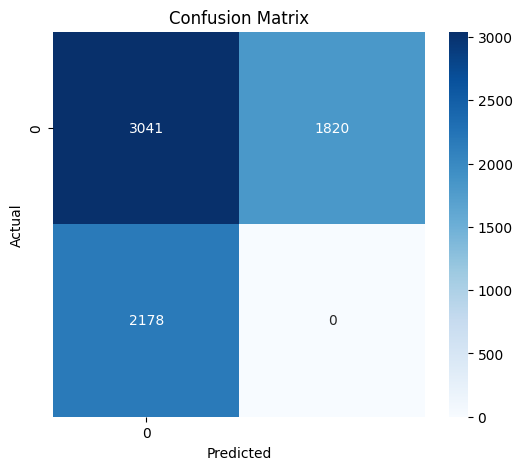

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm_matrix = cm.matrix  # Ambil array 2D dari ConfusionMatrix
classes = model.names  # Misalnya: ['D00']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_matrix, annot=True, fmt='.0f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

🖼 Menampilkan: confusion_matrix.png


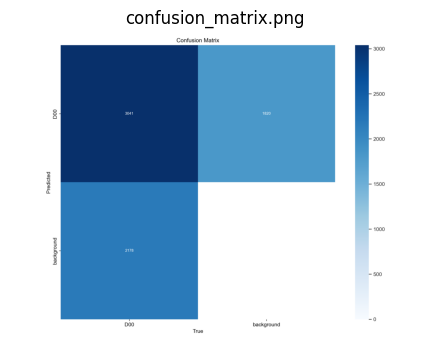

🖼 Menampilkan: confusion_matrix_normalized.png


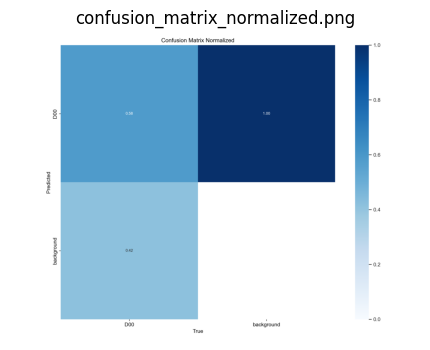

🖼 Menampilkan: F1_curve.png


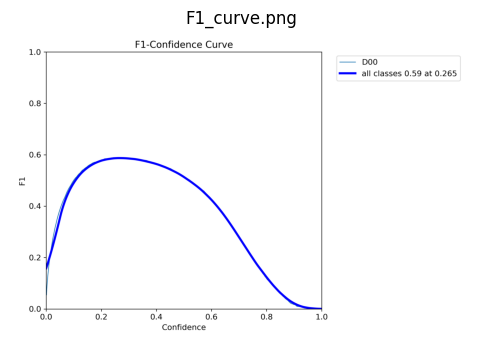

🖼 Menampilkan: PR_curve.png


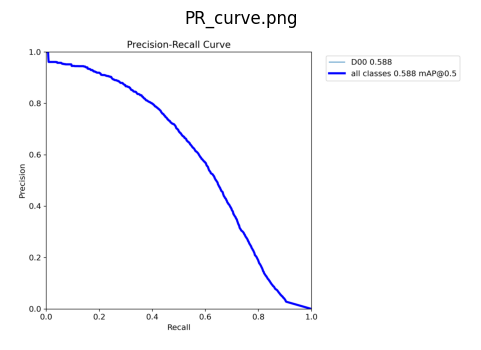

🖼 Menampilkan: P_curve.png


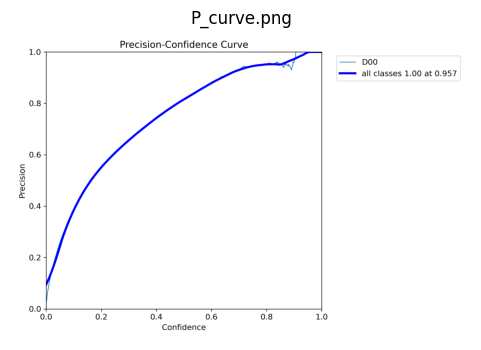

🖼 Menampilkan: R_curve.png


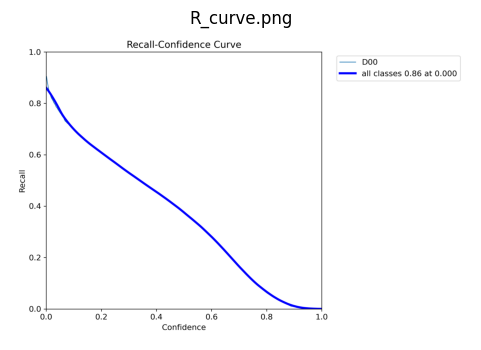

🖼 Menampilkan: val_batch0_labels.jpg


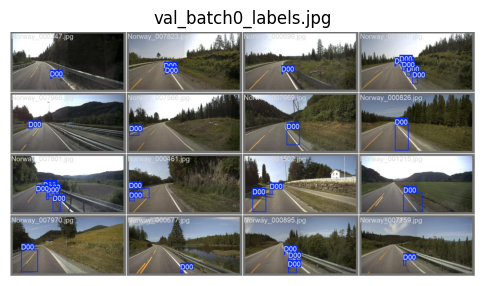

🖼 Menampilkan: val_batch0_pred.jpg


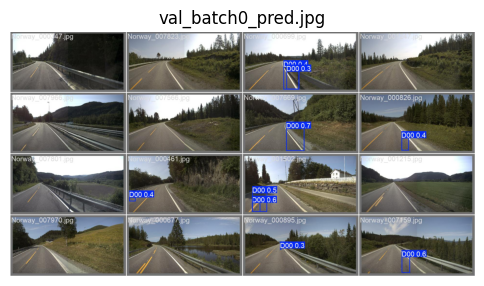

🖼 Menampilkan: val_batch1_labels.jpg


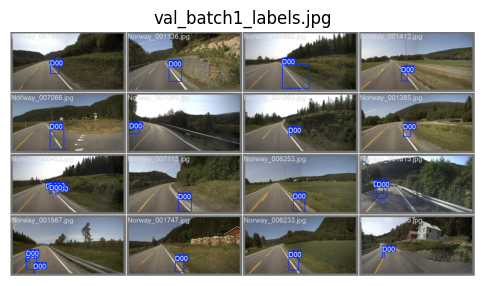

🖼 Menampilkan: val_batch1_pred.jpg


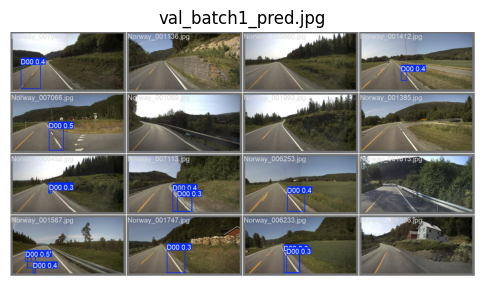

🖼 Menampilkan: val_batch2_labels.jpg


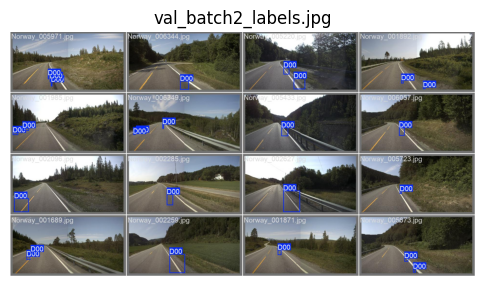

🖼 Menampilkan: val_batch2_pred.jpg


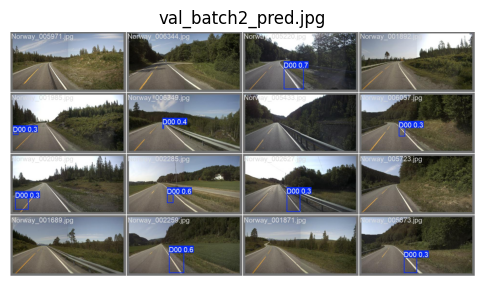

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_extensions = ['.jpg', '.jpeg', '.png']

for root, dirs, files in os.walk(target_dir):
    for file in files:
        if os.path.splitext(file)[1].lower() in image_extensions:
            path = os.path.join(root, file)
            print(f"🖼 Menampilkan: {file}")
            img = mpimg.imread(path)
            plt.figure(figsize=(6, 4))
            plt.imshow(img)
            plt.title(file)
            plt.axis('off')
            plt.show()

In [49]:
mp = metrics.box.mp    # mean precision (float)
mr = metrics.box.mr    # mean recall (float)
map50 = metrics.box.map50  # mAP@0.5 (float)
map5095 = metrics.box.map    # mAP@0.5:0.95 (float)
f1_scores = metrics.box.f1  # list F1 score per kelas
mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

print(f"Precision (mean): {mp:.4f}")
print(f"Recall (mean): {mr:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.5:0.95: {map5095:.4f}")
print(f"F1-score (mean): {mean_f1:.4f}")

Precision (mean): 0.6249
Recall (mean): 0.5564
mAP@0.5: 0.5884
mAP@0.5:0.95: 0.3201
F1-score (mean): 0.5887


In [52]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load model yang sudah kamu train
model = YOLO('yolov8n.pt')  # sesuaikan path model terbaikmu

# Fungsi untuk load gambar dari file input (misal file dialog atau path file langsung)
def predict_from_file(image_path):
    img = cv2.imread(image_path)
    # Resize lebih kecil agar lebih cepat
    img = cv2.resize(img, (640, 640))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    results = model(img_rgb)
    
    result_img = results[0].plot()
    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.show()


# Contoh panggil fungsi dengan file input gambar
predict_from_file("dataset-mix/train/images/United_States_000068.jpg")

FileUpload(value=(), accept='image/*', description='Upload')